# Reward-based POIS analysis
In this notebook we are going to show the results of the reward-based importance weighting for the POIS algorithm. As in PDIS notebook, we start by loading all our runs and by defining a base run filter.

In [24]:
import pandas as pd
import numpy as np
import glob, sys, json, re
import matplotlib.pyplot as plt
import scipy.stats as sts
from sacred_notebook_utils import load_runs, filter_runs, plot_mean_ci, plot_all

In [25]:
runs = load_runs('../sacred_runs/')
print("Loaded runs:", len(runs.keys()))

Loaded runs: 354


In [26]:
base_query = {
    'run.status': 'COMPLETED',
    'config.center': False,
    'config.gamma': 0.99,
    'config.clipping': False,
    'config.njobs': 1,
    'config.natural': False,
    'config.policy': 'linear',
    'config.iw_norm': 'none'
}

## CartPole as a test
Now we are going to see if the reward-based POIS has a comparative performance w.r.t. vanilla POIS, given also that in the CartPole environment the rewards are very broadly distributed, since the reward is simply the length of the episode times 10. It ranges from 0 to 5000. This means that, without any reward clustering, the reward-based estimator should work the same as the vanilla estimator.

----------------------------------------
Method: is  - Entropy: none
Experiments: 5
Seeds: 109, 570, 10, 160, 904
----------------------------------------
Method: rbis  - Entropy: none
Experiments: 5
Seeds: 160, 570, 109, 10, 904
----------------------------------------
Method: rbis  - Entropy: none
Experiments: 5
Seeds: 570, 10, 904, 109, 160
----------------------------------------
Method: rbis  - Entropy: none
Experiments: 5
Seeds: 160, 570, 10, 109, 904


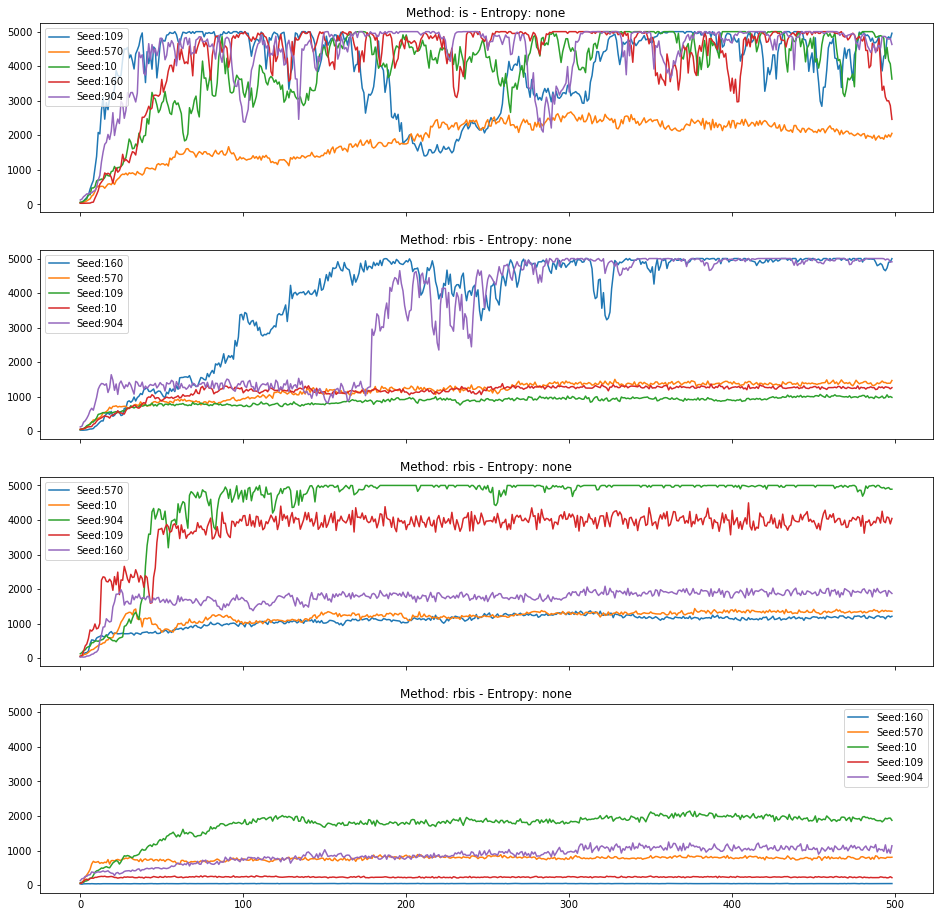

In [29]:
fig, axis = plt.subplots(nrows=4, ncols=1, figsize=(16,16), sharex=True, sharey=True)
for i, (method, delta) in enumerate([('is', 0.4),
                                              ('rbis', 0.4),
                                              ('rbis', 0.6),
                                              ('rbis', 0.9)
                                             ]):
    query = {
        'config.entropy': 'none',
        'config.env': 'rllab.cartpole',
        'config.iw_method': method,
        'config.delta': delta,
        'config.bound': 'max-d2',
        'config.num_episodes': 100
    }
    filtered_runs = filter_runs({**base_query, **query}, runs)
    print('----------------------------------------')
    print("Method:", method, " - Entropy:", entropy)
    print("Experiments:", len(filtered_runs.keys()))
    print("Seeds:", ", ".join(map(str, [filtered_runs[key]['config']['seed'] for key in filtered_runs.keys()])))
    plot_all(filtered_runs, 'EpRewMean', axis[i])
    axis[i].set_title("Method: " + method + " - Entropy: " + entropy)
plt.show();

As we can see, RB has more difficulties converging. This could be because of the bound, so we reiterate the experiment with different deltas to see if there is a difference.

# TODO
- Different deltas to make cartpole work
- Cartpole with increasing reward_clustering N